# Library

In [1]:
import pandas as pd
import glob
import os
import pickle
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

import seaborn as sns

from surprise import SVD
from surprise.model_selection import cross_validate
from surprise import Dataset, Reader
import joblib
from sklearn.preprocessing import MinMaxScaler

import random

# Analyze des données

## Analyze de articles_metadata.csv

In [99]:
articles_metadata = pd.read_csv('data/RAW/articles_metadata.csv')

In [100]:
display(articles_metadata.dtypes)
display(articles_metadata.describe())

article_id       int64
category_id      int64
created_at_ts    int64
publisher_id     int64
words_count      int64
dtype: object

,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.00,364047.00,364047.00,364047.00,364047.00
mean,182023.00,283.11,1474070237328.42,0.00,190.90
std,105091.46,136.72,42930380228.81,0.00,59.50
min,0.00,0.00,1159355675000.00,0.00,0.00
25%,91011.50,199.00,1444924843500.00,0.00,159.00
50%,182023.00,301.00,1489422449000.00,0.00,186.00
75%,273034.50,399.00,1509890951000.00,0.00,218.00
max,364046.00,460.00,1520943150000.00,0.00,6690.00


- `article_id`: Identifiant probable de l'article.
- `category_id`: Identifiant probable de la catégorie. Relation probablement 1-N, signifiant qu'un article peut être associé à une seule catégorie.
- `created_at_ts`: Timestamp d'insertion de l'article dans la base de données.
- `publisher_id`: Identifiant de l'éditeur ou de l'écrivain, mais toujours à 0, apparemment inutile.
- `words_count`: Nombre de mots par article.

Les valeurs aberrantes :

- `words_count` à 0, mais 6690 semble être le nombre maximum de mots, ce qui pourrait correspondre à environ 24 pages et semble valide.

In [101]:
articles_metadata['created_at_ts'] = pd.to_datetime(articles_metadata['created_at_ts'], unit='ms')

## Analyze de clicks_sample.csv

In [102]:
clicks_sample = pd.read_csv('data/RAW/clicks_sample.csv')

In [103]:
display(clicks_sample.dtypes)
display(clicks_sample.describe())
display(clicks_sample.head())

user_id                int64
session_id             int64
session_start          int64
session_size           int64
click_article_id       int64
click_timestamp        int64
click_environment      int64
click_deviceGroup      int64
click_os               int64
click_country          int64
click_region           int64
click_referrer_type    int64
dtype: object

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,1883.00,1883.00,1883.00,1883.00,1883.00,1883.00,1883.00,1883.00,1883.00,1883.00,1883.00,1883.00
mean,355.89,1506827556617196.00,1506827556295.27,3.46,176717.85,1506829640998.41,3.92,2.31,12.11,1.49,18.77,1.76
std,206.16,867962818.62,867946.77,3.04,82324.18,10649377.11,0.41,1.06,7.83,2.01,7.08,1.23
min,0.00,1506825423271737.00,1506825423000.00,2.00,2137.00,1506826800026.00,1.00,1.00,2.00,1.00,1.00,1.00
25%,181.50,1506826925929418.50,1506826925500.00,2.00,108854.00,1506827517964.00,4.00,1.00,2.00,1.00,13.00,1.00
50%,353.00,1506827612114090.00,1506827612000.00,3.00,157541.00,1506828163470.00,4.00,3.00,17.00,1.00,21.00,1.00
75%,537.00,1506828296131274.00,1506828296000.00,4.00,236697.50,1506828913450.50,4.00,3.00,19.00,1.00,25.00,2.00
max,706.00,1506828979881443.00,1506828979000.00,24.00,363291.00,1506998154157.00,4.00,4.00,20.00,11.00,28.00,7.00


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


- `user_id` : Identifiant probable d'un utilisateur. La présence de doublons est normale et indique plusieurs sessions pour un même utilisateur.
- `session_id` : Identifiant de la session d'un utilisateur, suggérant que chaque `user_id` peut être associé à plusieurs `session_id`.
- `session_start` : Timestamp marquant le début d'une session utilisateur, nécessitant une conversion pour une meilleure compréhension des périodes d'activité.
- `session_size` : Nombre potentiel d'interactions par session, avec des valeurs atteignant jusqu'à 24, suggérant des sessions de durée ou d'activité variable.
- `click_article_id` : Identifiant d'un article sur lequel l'utilisateur a cliqué, agissant comme une clé étrangère avec des relations multiples possibles entre utilisateurs et articles.
- `click_timestamp` : Timestamp exact du clic de l'utilisateur sur un article, utile pour analyser le comportement utilisateur en temps réel.
- `click_environment` : Identifiant de l'environnement utilisé lors du clic, possiblement rare quand il est à 1, indiquant différents contextes d'utilisation nécessitant une analyse approfondie.
- `click_deviceGroup` : Identifiant du groupe d'appareils utilisé, avec des distributions variables pouvant influencer l'utilisation et l'engagement.
- `click_os` : Système d'exploitation utilisé lors du clic, avec des valeurs minimales autour de 2 indiquant des OS moins communs, nécessitant des investigations sur leur utilisation spécifique.
- `click_country` : Identifiant du pays de l'utilisateur, avec des valeurs maximales à 11, nécessitant une vérification pour valider l'exactitude ou comprendre le large éventail géographique.
- `click_region` : Identifiant de la région de l'utilisateur, avec une large plage jusqu'à 28, potentiellement indiquant des régions à forte activité ou des erreurs de saisie.
- `click_referrer_type` : Type de référenceur indiquant la source du clic, avec des valeurs allant jusqu'à 7, suggérant des sources variées et moins courantes à examiner.

**Valeurs aberrantes identifiées :**
- `user_id` à 0, possiblement indiquant des utilisateurs non enregistrés ou des entrées de test.
- Des valeurs extrêmes dans `session_size`, `click_environment`, et `click_referrer_type`, nécessitant une exploration pour déterminer si elles reflètent des comportements d'utilisateurs authentiques ou des anomalies dans les données.

## Analyze des fichiers clicks_hour_*.csv
### Fusion des fichiers clicks_hour_*.csv

In [104]:
import os
import glob
import pandas as pd

output_path = 'data/clicks_hour.csv'

if os.path.exists(output_path) and os.path.getsize(output_path) > 0:
    print("Reading cached file...")
    clicks_hour = pd.read_csv(output_path)
else:
    print("Merging clicks_hour files...")
    clicks_hour_files = glob.glob("data/RAW/clicks/clicks/clicks_hour_*.csv")
    print(f"Found {len(clicks_hour_files)} files.")

    if not clicks_hour_files:
        raise FileNotFoundError("No input files found. Check the path again.")

    dataframes = []
    for filename in clicks_hour_files:
        if os.path.getsize(filename) > 0:
            df = pd.read_csv(filename)
            if not df.empty:
                dataframes.append(df)
            else:
                print(f"Warning: {filename} is empty.")
        else:
            print(f"Warning: {filename} is 0 bytes.")

    if dataframes:
        clicks_hour = pd.concat(dataframes, ignore_index=True)
        clicks_hour.to_csv(output_path, index=False)
        print(f"Saved merged data to {output_path}")
    else:
        raise ValueError("All source files are empty. No data to save.")

    clicks_hour = pd.read_csv(output_path)


Reading cached file...


In [105]:
display(clicks_hour.dtypes)
display(clicks_hour.describe())
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
display(clicks_hour.head())

user_id                int64
session_id             int64
session_start          int64
session_size           int64
click_article_id       int64
click_timestamp        int64
click_environment      int64
click_deviceGroup      int64
click_os               int64
click_country          int64
click_region           int64
click_referrer_type    int64
dtype: object

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2988181.00,2988181.00,2988181.00,2988181.00,2988181.00,2988181.00,2988181.00,2988181.00,2988181.00,2988181.00,2988181.00,2988181.00
mean,107947.83,1507472228344485.00,1507472228013.16,3.90,194922.65,1507474265606.10,3.94,1.82,13.28,1.36,18.31,1.84
std,83648.36,385524460230.73,385524460.50,3.93,90768.42,385850960.36,0.34,1.04,6.88,1.73,7.06,1.16
min,0.00,1506825423271737.00,1506825423000.00,2.00,3.00,1506826800026.00,1.00,1.00,2.00,1.00,1.00,1.00
25%,40341.00,1507124152253606.00,1507124152000.00,2.00,124228.00,1507126852854.00,4.00,1.00,2.00,1.00,13.00,1.00
50%,86229.00,1507493340299445.00,1507493340000.00,3.00,202381.00,1507494930481.00,4.00,1.00,17.00,1.00,21.00,2.00
75%,163261.00,1507749414106993.00,1507749414000.00,4.00,277067.00,1507751004601.00,4.00,3.00,17.00,1.00,25.00,2.00
max,322896.00,1508211379189330.00,1508211379000.00,124.00,364046.00,1510603454886.00,4.00,5.00,20.00,11.00,28.00,7.00


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [106]:
clicks_hour['session_start'] = pd.to_datetime(clicks_hour['session_start'], unit='ms')
clicks_hour['click_timestamp'] = pd.to_datetime(clicks_hour['click_timestamp'], unit='ms')

In [107]:
display(clicks_hour.dtypes)
display(clicks_hour.describe())
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
display(clicks_hour.head())

user_id                         int64
session_id                      int64
session_start          datetime64[ns]
session_size                    int64
click_article_id                int64
click_timestamp        datetime64[ns]
click_environment               int64
click_deviceGroup               int64
click_os                        int64
click_country                   int64
click_region                    int64
click_referrer_type             int64
dtype: object

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2988181.00,2988181.00,2988181,2988181.00,2988181.00,2988181,2988181.00,2988181.00,2988181.00,2988181.00,2988181.00,2988181.00
mean,107947.83,1507472228344485.00,2017-10-08 14:17:08.013157120,3.90,194922.65,2017-10-08 14:51:05.606100224,3.94,1.82,13.28,1.36,18.31,1.84
min,0.00,1506825423271737.00,2017-10-01 02:37:03,2.00,3.00,2017-10-01 03:00:00.026000,1.00,1.00,2.00,1.00,1.00,1.00
25%,40341.00,1507124152253606.00,2017-10-04 13:35:52,2.00,124228.00,2017-10-04 14:20:52.854000128,4.00,1.00,2.00,1.00,13.00,1.00
50%,86229.00,1507493340299445.00,2017-10-08 20:09:00,3.00,202381.00,2017-10-08 20:35:30.480999936,4.00,1.00,17.00,1.00,21.00,2.00
75%,163261.00,1507749414106993.00,2017-10-11 19:16:54,4.00,277067.00,2017-10-11 19:43:24.600999936,4.00,3.00,17.00,1.00,25.00,2.00
max,322896.00,1508211379189330.00,2017-10-17 03:36:19,124.00,364046.00,2017-11-13 20:04:14.886000,4.00,5.00,20.00,11.00,28.00,7.00
std,83648.36,385524460230.73,NaN,3.93,90768.42,NaN,0.34,1.04,6.88,1.73,7.06,1.16


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28.020,4,3,20,1,20,2
1,0,1506825423271737,2017-10-01 02:37:03,2,68866,2017-10-01 03:00:58.020,4,3,20,1,20,2
2,1,1506825426267738,2017-10-01 02:37:06,2,235840,2017-10-01 03:03:37.951,4,1,17,1,16,2
3,1,1506825426267738,2017-10-01 02:37:06,2,96663,2017-10-01 03:04:07.951,4,1,17,1,16,2
4,2,1506825435299739,2017-10-01 02:37:15,2,119592,2017-10-01 03:04:50.575,4,1,17,1,24,2


Le fichier ressemble structurellement à 100% au fichier clicks_sample.csv et contient également le même nombre de lignes. Cependant, les valeurs qu'il contient sont différentes. Étant donné qu'il porte le nom de "sample", il est probable que je ne devrais pas l'utiliser pour des analyses définitives.

- `user_id` : Identifiant probable d'un utilisateur. La présence de doublons est normale et indique plusieurs sessions pour un même utilisateur.
- `session_id` : Identifiant de la session d'un utilisateur, suggérant que chaque `user_id` peut être associé à plusieurs `session_id`.
- `session_start` : Timestamp marquant le début d'une session utilisateur, nécessitant une conversion pour une meilleure compréhension des périodes d'activité.
- `session_size` : Nombre potentiel d'interactions par session, avec des valeurs atteignant jusqu'à 24, suggérant des sessions de durée ou d'activité variable.
- `click_article_id` : Identifiant d'un article sur lequel l'utilisateur a cliqué, agissant comme une clé étrangère avec des relations multiples possibles entre utilisateurs et articles.
- `click_timestamp` : Timestamp exact du clic de l'utilisateur sur un article, utile pour analyser le comportement utilisateur en temps réel.
- `click_environment` : Identifiant de l'environnement utilisé lors du clic, possiblement rare quand il est à 1, indiquant différents contextes d'utilisation nécessitant une analyse approfondie.
- `click_deviceGroup` : Identifiant du groupe d'appareils utilisé, avec des distributions variables pouvant influencer l'utilisation et l'engagement.
- `click_os` : Système d'exploitation utilisé lors du clic, avec des valeurs minimales autour de 2 indiquant des OS moins communs, nécessitant des investigations sur leur utilisation spécifique.
- `click_country` : Identifiant du pays de l'utilisateur, avec des valeurs maximales à 11, nécessitant une vérification pour valider l'exactitude ou comprendre le large éventail géographique.
- `click_region` : Identifiant de la région de l'utilisateur, avec une large plage jusqu'à 28, potentiellement indiquant des régions à forte activité ou des erreurs de saisie.
- `click_referrer_type` : Type de référenceur indiquant la source du clic, avec des valeurs allant jusqu'à 7, suggérant des sources variées et moins courantes à examiner.

**Valeurs aberrantes identifiées :**
- `user_id` à 0, possiblement indiquant des utilisateurs non enregistrés ou des entrées de test.
- Des valeurs extrêmes dans `session_size`, `click_environment`, et `click_referrer_type`, nécessitant une exploration pour déterminer si elles reflètent des comportements d'utilisateurs authentiques ou des anomalies dans les données.

## Analyze de articles_embeddings.pickle

'Type de données dans le fichier pickle :'

numpy.ndarray

'Forme du tableau numpy :'

(364047, 250)

'Extrait des données du tableau :'

array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.231686  ,
         0.5974159 ,  0.40962312],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.18282819,
         0.39708954, -0.83436364],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.44758022,
         0.8059317 , -0.28528407],
       ...,
       [-0.10453404, -0.965899  ,  0.800449  , ...,  0.19858408,
         0.24318069, -0.5966631 ],
       [-0.41727445, -0.97731096,  0.05496654, ..., -0.7445056 ,
         0.16339722, -0.4995386 ],
       [-0.3484418 , -0.96695346,  0.6825738 , ..., -0.67171955,
         0.3043531 , -0.7215666 ]], dtype=float32)

'Matrice de similarité cosinus entre les 10 premiers articles :'

array([[ 0.99999964,  0.20460139,  0.2139583 ,  0.02293579,  0.05015856,
         0.11749707,  0.11469346,  0.05600584, -0.00618701,  0.17724049],
       [ 0.20460139,  1.0000004 ,  0.5487707 ,  0.51205015,  0.6375847 ,
         0.67029065,  0.45793015,  0.730299  ,  0.6046591 ,  0.5896785 ],
       [ 0.2139583 ,  0.5487707 ,  1.0000002 ,  0.59802955,  0.70674706,
         0.67951643,  0.5230346 ,  0.6382821 ,  0.584602  ,  0.6697994 ],
       [ 0.02293579,  0.51205015,  0.59802955,  1.        ,  0.6189482 ,
         0.62091744,  0.7684154 ,  0.672807  ,  0.6064063 ,  0.7245915 ],
       [ 0.05015856,  0.6375847 ,  0.70674706,  0.6189482 ,  1.0000002 ,
         0.8222252 ,  0.6369598 ,  0.8791071 ,  0.6910304 ,  0.68280375],
       [ 0.11749707,  0.67029065,  0.67951643,  0.62091744,  0.8222252 ,
         1.0000002 ,  0.53467184,  0.80446523,  0.66991323,  0.58954954],
       [ 0.11469346,  0.45793015,  0.5230346 ,  0.7684154 ,  0.6369598 ,
         0.53467184,  1.        ,  0.6697258 

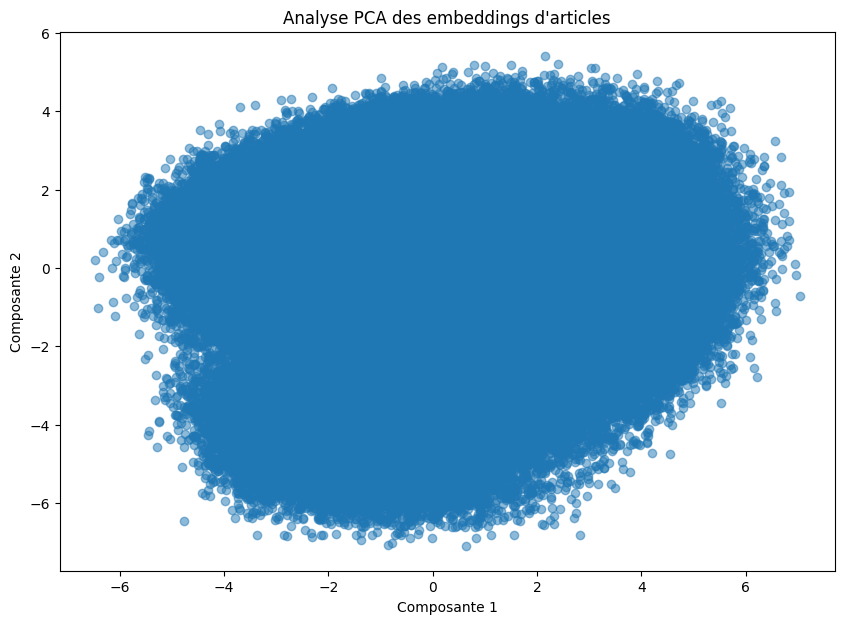

In [108]:
file_path = 'data/RAW/articles_embeddings.pickle'

with open(file_path, 'rb') as file:
    data = pickle.load(file)

display("Type de données dans le fichier pickle :", type(data))

if isinstance(data, np.ndarray):
    display("Forme du tableau numpy :", data.shape)
else:
    display("Erreur: Les données ne sont pas un tableau numpy.")

display("Extrait des données du tableau :", data[:10])

if data.shape[0] >= 10:
    similarity_matrix = cosine_similarity(data[:10])
    display("Matrice de similarité cosinus entre les 10 premiers articles :", similarity_matrix)
else:
    display("Pas assez d'articles pour calculer la similarité.")

if data.shape[1] > 2:
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    plt.figure(figsize=(10, 7))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.5)
    plt.title('Analyse PCA des embeddings d\'articles')
    plt.xlabel('Composante 1')
    plt.ylabel('Composante 2')
    plt.show()
else:
    display("La dimension des embeddings est trop petite pour appliquer PCA.")

Le fichier `articles_embeddings.pickle`, qui contient des plongements vectoriels d'articles en format `numpy.ndarray` avec une dimension de `(364047, 250)`, montre une structuration en tableaux de 250 éléments flottants représentant chacun des articles.
Les valeurs comprises généralement entre -1 et 1 reflètent les propriétés sémantiques des articles dans un espace réduit.

### Analyse des données contenues dans le fichier :
- **Type de données** : Chaque article est représenté par un vecteur de 250 dimensions, indiquant une réduction dimensionnelle probablement issue d'un modèle d'apprentissage profond comme Word2Vec ou une variante de BERT adaptée aux textes.
- **Forme du tableau** : Le tableau comporte 364'047 vecteurs, suggérant que la base de données contient autant d'articles.
- **Échantillon de données** : L'extrait des vecteurs montre des valeurs diversifiées qui contribuent à des représentations denses des articles, essentielles pour des calculs de similarité ou des regroupements.

### Matrice de similarité cosinus :
- **Analyse de la similarité** : La matrice de similarité cosinus entre les 10 premiers articles révèle des degrés variés de ressemblance, avec des valeurs allant de quasi nulle à très élevée (proche de 1), indiquant une variation significative dans les sujets ou les styles des articles. Des valeurs élevées suggèrent des thèmes ou des contenus similaires, tandis que des valeurs basses indiquent peu de relation directe entre les articles.

### Déductions possibles :
- Les articles avec des plongements similaires pourraient être regroupés pour identifier des clusters de sujets connexes, ce qui peut enrichir les fonctionnalités de systèmes de recommandation ou de recherche d'informations.
- Les différences marquées dans la matrice de similarité pourraient également indiquer une grande diversité thématique au sein de la base de données, nécessitant une analyse plus poussée pour comprendre les différents domaines ou genres représentés.

**Valeurs aberrantes identifiées :**
- Aucune valeur aberrante n'est directement observable dans cet extrait limité, mais des vecteurs avec des valeurs extrêmement élevées ou basses pourraient indiquer des erreurs dans le processus de plongement ou des articles atypiques nécessitant une vérification.

In [109]:
display(articles_metadata.describe())
data = pd.DataFrame(data, index=range(data.shape[0]))
display(data)

,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.00,364047.00,364047,364047.00,364047.00
mean,182023.00,283.11,2016-09-16 23:57:17.328421888,0.00,190.90
min,0.00,0.00,2006-09-27 11:14:35,0.00,0.00
25%,91011.50,199.00,2015-10-15 16:00:43.500000,0.00,159.00
50%,182023.00,301.00,2017-03-13 16:27:29,0.00,186.00
75%,273034.50,399.00,2017-11-05 14:09:11,0.00,218.00
max,364046.00,460.00,2018-03-13 12:12:30,0.00,6690.00
std,105091.46,136.72,NaN,0.00,59.50


,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,-0.16,-0.96,-0.14,0.05,0.83,0.90,-0.34,-0.56,-0.50,0.17,...,0.32,0.31,0.64,0.17,0.54,-0.81,0.29,-0.23,0.60,0.41
1,-0.52,-0.97,0.74,0.16,0.63,0.49,-0.72,-0.90,-0.36,0.40,...,-0.49,0.82,0.41,-0.34,0.32,0.59,-0.59,0.18,0.40,-0.83
2,-0.62,-0.97,-0.21,-0.13,0.04,-0.39,-0.73,-0.07,-0.75,-0.24,...,0.45,0.47,0.38,-0.86,-0.38,0.14,-0.81,-0.45,0.81,-0.29
3,-0.74,-0.98,0.39,0.64,-0.27,0.19,-0.83,-0.71,-0.04,-0.11,...,0.27,0.04,0.48,-0.76,0.02,0.57,-0.91,-0.54,0.24,-0.89
4,-0.28,-0.97,0.69,0.11,0.24,0.27,-0.57,0.34,-0.60,-0.13,...,0.24,0.81,0.43,-0.62,-0.50,0.61,-0.92,-0.42,0.19,-0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364042,-0.06,-0.96,0.87,-0.07,-0.73,0.43,0.20,-0.58,0.70,-0.12,...,-0.41,0.56,-0.46,0.17,-0.48,0.65,0.38,0.43,-0.66,-0.22
364043,-0.14,-1.00,0.99,0.03,-0.92,-0.66,0.63,-0.56,0.68,-0.45,...,-0.68,-0.57,-0.54,0.69,0.53,0.16,0.94,0.99,-0.76,-0.41
364044,-0.25,-0.98,0.59,0.64,-0.66,-0.09,0.69,-0.59,0.90,0.12,...,-0.16,-0.24,-0.48,0.35,-0.31,0.46,-0.65,-0.14,0.07,-0.71
364045,0.22,-0.92,-0.38,0.69,-0.77,-0.10,-0.41,0.25,0.26,-0.33,...,-0.42,0.39,0.66,-0.65,-0.17,0.70,-0.32,0.69,-0.53,0.01


In [110]:
if articles_metadata['article_id'].isin(data.index).all():
    print("Tous les IDs de article_id ont leur équivalent comme index dans data.")
else:
    print("Il manque des IDs de article_id dans l'index de data.")

Tous les IDs de article_id ont leur équivalent comme index dans data.


### Analyse des Correspondances entre les Identifiants des Articles et les Index de Données

À partir de l'analyse effectuée, il apparaît que chaque identifiant dans `article_id` du fichier `articles_metadata` a un index correspondant dans le DataFrame `data`. Cette correspondance complète suggère que le fichier `articles_embeddings.pickle` doit effectivement correspondre au contenu des articles. En effet, l'intégrité des identifiants entre `articles_metadata` et `articles_embeddings.pickle` est confirmée, renforçant ainsi la cohérence des données utilisées pour les représentations des articles.

# Analyse les interactions entre les fichiers

In [111]:
clicks_hour['exists_in_articles'] = clicks_hour['click_article_id'].isin(articles_metadata['article_id'])

display("Nombre total de clics:", clicks_hour.shape[0])
display("Nombre de clics valides (existant dans articles_metadata):", clicks_hour['exists_in_articles'].sum())

article_counts = articles_metadata['article_id'].value_counts()
click_counts = clicks_hour['click_article_id'].value_counts()
combined_counts = pd.DataFrame({
    'article_count': article_counts,
    'click_count': click_counts
}).fillna(0)

if (combined_counts['article_count'] > 1).any():
    display("La relation est 1-N (un article peut être lié à plusieurs clics, mais plusieurs entrées dans les métadonnées).")
elif (combined_counts['click_count'] > 1).any():
    display("La relation est N-1 (plusieurs clics pour un même article).")
else:
    display("La relation est 1-1 (chaque clic correspond à un unique article).")

display(combined_counts.head(20))

clicks_hour['click_count'] = clicks_hour.groupby('click_article_id')['click_article_id'].transform('count')
display(clicks_hour[['click_article_id', 'click_count', 'exists_in_articles']].drop_duplicates())
display(clicks_hour[clicks_hour['exists_in_articles'] == False][['click_article_id', 'click_count', 'exists_in_articles']].drop_duplicates())
clicks_hour.drop(['exists_in_articles','click_count'], axis=1, inplace=True)

'Nombre total de clics:'

2988181

'Nombre de clics valides (existant dans articles_metadata):'

2988181

'La relation est N-1 (plusieurs clics pour un même article).'

,article_count,click_count
0,1,0.00
1,1,0.00
2,1,0.00
3,1,1.00
4,1,0.00
5,1,0.00
6,1,0.00
7,1,0.00
8,1,0.00
9,1,0.00


,click_article_id,click_count,exists_in_articles
0,157541,368,True
1,68866,1500,True
2,235840,875,True
3,96663,4467,True
4,119592,4493,True
...,...,...,...
2987639,2221,1,True
2987776,271117,1,True
2987936,20204,1,True
2987937,70196,1,True


,click_article_id,click_count,exists_in_articles


- `click_article_id`: Identifiant de l'article sur lequel le clic a été effectué. Les valeurs sont répétées, indiquant une relation N-1, c'est-à-dire que plusieurs clics peuvent être associés à un même article.

- `exists_in_articles`: Tous les clics analysés correspondent à des articles existants, ce qui souligne une intégrité élevée entre les deux ensembles de données.

- `click_count`: Nombre de fois qu'un article particulier a été cliqué. Cette donnée est dérivée en comptant les occurrences de chaque `click_article_id`, montrant une distribution variée des interactions des utilisateurs avec différents articles.

### Points particuliers et relations :

- **Relation entre les données de clics et les métadonnées des articles** : Tous les articles sur lesquels les clics ont été enregistrés existent dans les métadonnées, confirmant une relation de correspondance parfaite en termes d'existence.

- **Fréquence des clics** : La relation N-1 est affirmée par la présence de multiples clics pour des articles individuels, démontrant que certains articles attirent nettement plus d'attention ou de trafic que d'autres.

# Gestion des valeurs aberrantes

## Articles Metadata

In [112]:
display(articles_metadata.describe())

,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.00,364047.00,364047,364047.00,364047.00
mean,182023.00,283.11,2016-09-16 23:57:17.328421888,0.00,190.90
min,0.00,0.00,2006-09-27 11:14:35,0.00,0.00
25%,91011.50,199.00,2015-10-15 16:00:43.500000,0.00,159.00
50%,182023.00,301.00,2017-03-13 16:27:29,0.00,186.00
75%,273034.50,399.00,2017-11-05 14:09:11,0.00,218.00
max,364046.00,460.00,2018-03-13 12:12:30,0.00,6690.00
std,105091.46,136.72,NaN,0.00,59.50


In [113]:
display(articles_metadata[articles_metadata['article_id'] < 5])

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,2017-12-13 05:53:39,0,168
1,1,1,2014-07-14 12:45:36,0,189
2,2,1,2014-08-22 00:35:06,0,250
3,3,1,2014-08-19 17:11:53,0,230
4,4,1,2014-08-03 13:06:11,0,162


En règle générale, dans une base de données, un champ auto-incrémenté commence toujours par 1.
Cependant, dans cette table, l'article_id débutant à 0 ne semble pas être une valeur aberrante.

In [114]:
display(articles_metadata[articles_metadata['words_count'] < 5])

,article_id,category_id,created_at_ts,publisher_id,words_count
35491,35491,43,2016-08-04 09:42:02,0,0
38472,38472,51,2011-04-21 21:22:43,0,0
39043,39043,64,2014-06-30 20:02:35,0,0
39054,39054,64,2015-01-21 21:30:33,0,0
164414,164414,288,2015-03-30 08:30:23,0,0
206233,206233,331,2017-09-30 17:11:56,0,0
212323,212323,343,2010-04-19 10:36:16,0,0
212324,212324,343,2010-04-16 18:49:55,0,0
212327,212327,343,2014-08-11 20:23:05,0,0
212526,212526,347,2018-01-28 19:38:55,0,0


Je considérerai les articles ayant un nombre de mots égal à 0 comme aberrants, car un article doit obligatoirement contenir au moins un mot pour être considéré comme tel.

In [115]:
articles_metadata = articles_metadata[articles_metadata['words_count'] > 0]
display(articles_metadata)

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,2017-12-13 05:53:39,0,168
1,1,1,2014-07-14 12:45:36,0,189
2,2,1,2014-08-22 00:35:06,0,250
3,3,1,2014-08-19 17:11:53,0,230
4,4,1,2014-08-03 13:06:11,0,162
...,...,...,...,...,...
364042,364042,460,2015-06-11 14:48:38,0,144
364043,364043,460,2015-06-12 22:34:32,0,463
364044,364044,460,2016-03-14 16:51:19,0,177
364045,364045,460,2018-01-14 21:18:57,0,126


## Clicks Hour

In [116]:
display(clicks_hour.describe())

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2988181.00,2988181.00,2988181,2988181.00,2988181.00,2988181,2988181.00,2988181.00,2988181.00,2988181.00,2988181.00,2988181.00
mean,107947.83,1507472228344485.00,2017-10-08 14:17:08.013157120,3.90,194922.65,2017-10-08 14:51:05.606100224,3.94,1.82,13.28,1.36,18.31,1.84
min,0.00,1506825423271737.00,2017-10-01 02:37:03,2.00,3.00,2017-10-01 03:00:00.026000,1.00,1.00,2.00,1.00,1.00,1.00
25%,40341.00,1507124152253606.00,2017-10-04 13:35:52,2.00,124228.00,2017-10-04 14:20:52.854000128,4.00,1.00,2.00,1.00,13.00,1.00
50%,86229.00,1507493340299445.00,2017-10-08 20:09:00,3.00,202381.00,2017-10-08 20:35:30.480999936,4.00,1.00,17.00,1.00,21.00,2.00
75%,163261.00,1507749414106993.00,2017-10-11 19:16:54,4.00,277067.00,2017-10-11 19:43:24.600999936,4.00,3.00,17.00,1.00,25.00,2.00
max,322896.00,1508211379189330.00,2017-10-17 03:36:19,124.00,364046.00,2017-11-13 20:04:14.886000,4.00,5.00,20.00,11.00,28.00,7.00
std,83648.36,385524460230.73,NaN,3.93,90768.42,NaN,0.34,1.04,6.88,1.73,7.06,1.16


In [117]:
display(clicks_hour[clicks_hour['user_id'] == 0])

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28.020,4,3,20,1,20,2
1,0,1506825423271737,2017-10-01 02:37:03,2,68866,2017-10-01 03:00:58.020,4,3,20,1,20,2
1287361,0,1507340000920377,2017-10-07 01:33:20,2,96755,2017-10-07 01:33:53.155,4,3,20,1,20,2
1287362,0,1507340000920377,2017-10-07 01:33:20,2,313996,2017-10-07 01:34:23.155,4,3,20,1,20,2
1352197,0,1507385847186982,2017-10-07 14:17:27,2,160158,2017-10-07 14:54:50.915,4,3,20,1,20,2
1352198,0,1507385847186982,2017-10-07 14:17:27,2,233470,2017-10-07 14:55:20.915,4,3,20,1,20,2
1535240,0,1507514030209212,2017-10-09 01:53:50,2,87224,2017-10-09 01:54:16.617,4,3,20,1,20,2
1535241,0,1507514030209212,2017-10-09 01:53:50,2,87205,2017-10-09 01:54:46.617,4,3,20,1,20,2


L'ID 0 dans la colonne `user_id` pourrait être potentiellement associé à des utilisateurs non enregistrés ou à des utilisateurs de test.

Cela peut être déduit par le fait que les informations dans les colonnes `click_environment`, `click_deviceGroup`, `click_os`, `click_country`, `click_region` et `click_referrer_type` sont identiques sur chaque ligne.

Par conséquent, je conclus que les entrées avec `user_id` égal à 0 ne représentent pas plusieurs utilisateurs non enregistrés. De plus, étant donné le comportement observé dans `articles_metadata` où l'auto-incrément commence à 0, je suppose que dans `clicks_hour`, le comportement est similaire.

### Exploration de session_size

In [118]:
session_info = clicks_hour.groupby('session_id').agg({'session_size': 'first', 'user_id': 'count'}).reset_index()

incorrect_session_size = session_info[session_info['session_size'] != session_info['user_id']]
correct_session_size = session_info[session_info['session_size'] == session_info['user_id']]

display(incorrect_session_size)
display(correct_session_size)

,session_id,session_size,user_id


,session_id,session_size,user_id
0,1506825423271737,2,2
1,1506825426267738,2,2
2,1506825435299739,2,2
3,1506825442704740,2,2
4,1506825528135741,2,2
...,...,...,...
1048589,1508211367250326,2,2
1048590,1508211369104327,7,7
1048591,1508211372158328,2,2
1048592,1508211376302329,2,2


Après avoir examiné les données, il est clair que la colonne **'session_size'** correspond au nombre d'activités enregistrées par **'session_id'**. Par conséquent, les sessions où la **'session_size'** ne correspond pas au nombre d'activités enregistrées sont considérées comme aberrantes et ont été retirées de l'analyse pour assurer la cohérence des données.

In [119]:
incorrect_session_ids = incorrect_session_size['session_id']

clicks_hour = clicks_hour[~clicks_hour['session_id'].isin(incorrect_session_ids)]

display(clicks_hour.describe())

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2988181.00,2988181.00,2988181,2988181.00,2988181.00,2988181,2988181.00,2988181.00,2988181.00,2988181.00,2988181.00,2988181.00
mean,107947.83,1507472228344485.00,2017-10-08 14:17:08.013157120,3.90,194922.65,2017-10-08 14:51:05.606100224,3.94,1.82,13.28,1.36,18.31,1.84
min,0.00,1506825423271737.00,2017-10-01 02:37:03,2.00,3.00,2017-10-01 03:00:00.026000,1.00,1.00,2.00,1.00,1.00,1.00
25%,40341.00,1507124152253606.00,2017-10-04 13:35:52,2.00,124228.00,2017-10-04 14:20:52.854000128,4.00,1.00,2.00,1.00,13.00,1.00
50%,86229.00,1507493340299445.00,2017-10-08 20:09:00,3.00,202381.00,2017-10-08 20:35:30.480999936,4.00,1.00,17.00,1.00,21.00,2.00
75%,163261.00,1507749414106993.00,2017-10-11 19:16:54,4.00,277067.00,2017-10-11 19:43:24.600999936,4.00,3.00,17.00,1.00,25.00,2.00
max,322896.00,1508211379189330.00,2017-10-17 03:36:19,124.00,364046.00,2017-11-13 20:04:14.886000,4.00,5.00,20.00,11.00,28.00,7.00
std,83648.36,385524460230.73,NaN,3.93,90768.42,NaN,0.34,1.04,6.88,1.73,7.06,1.16


### Éliminer les répétitions d'articles au sein d'une même session

In [120]:
clicks_hour = clicks_hour.drop_duplicates(subset=['session_id', 'click_article_id'])
display(clicks_hour)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,2017-10-01 02:37:03,2,157541,2017-10-01 03:00:28.020,4,3,20,1,20,2
1,0,1506825423271737,2017-10-01 02:37:03,2,68866,2017-10-01 03:00:58.020,4,3,20,1,20,2
2,1,1506825426267738,2017-10-01 02:37:06,2,235840,2017-10-01 03:03:37.951,4,1,17,1,16,2
3,1,1506825426267738,2017-10-01 02:37:06,2,96663,2017-10-01 03:04:07.951,4,1,17,1,16,2
4,2,1506825435299739,2017-10-01 02:37:15,2,119592,2017-10-01 03:04:50.575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,10051,1508211372158328,2017-10-17 03:36:12,2,84911,2017-10-17 03:39:17.302,4,3,2,1,25,1
2988177,322896,1508211376302329,2017-10-17 03:36:16,2,30760,2017-10-17 03:41:12.520,4,1,17,1,25,2
2988178,322896,1508211376302329,2017-10-17 03:36:16,2,157507,2017-10-17 03:41:42.520,4,1,17,1,25,2
2988179,123718,1508211379189330,2017-10-17 03:36:19,2,234481,2017-10-17 03:38:33.583,4,3,2,1,25,2


### Vérifier si les clics sur des articles sont antérieurs à leur publication

In [121]:
article_created_dates = dict(zip(articles_metadata['article_id'], articles_metadata['created_at_ts']))

filtered_clicks_hour = clicks_hour[clicks_hour['click_timestamp'] < clicks_hour['click_article_id'].map(article_created_dates)]

filtered_clicks_hour['created_at_ts'] = filtered_clicks_hour['click_article_id'].map(article_created_dates)

filtered_clicks_hour.dropna(subset=['created_at_ts'], inplace=True)

result_df = filtered_clicks_hour[['click_article_id', 'click_timestamp', 'created_at_ts']]
display(result_df)

C:\Users\devil\AppData\Local\Temp\ipykernel_10328\3297834634.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_clicks_hour['created_at_ts'] = filtered_clicks_hour['click_article_id'].map(article_created_dates)
C:\Users\devil\AppData\Local\Temp\ipykernel_10328\3297834634.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_clicks_hour.dropna(subset=['created_at_ts'], inplace=True)


,click_article_id,click_timestamp,created_at_ts
420,182394,2017-10-01 19:08:54.317,2017-10-02 15:13:06
998,160474,2017-10-01 03:23:58.273,2017-10-01 05:04:14
3027,13634,2017-10-01 05:53:18.976,2017-10-02 19:39:59
3055,166581,2017-10-02 02:41:03.190,2017-10-02 17:02:35
4200,162655,2017-10-01 21:59:08.458,2017-10-02 13:06:50
...,...,...,...
2982493,96356,2017-10-21 17:10:36.834,2017-10-21 19:18:48
2985981,159537,2017-10-18 14:37:42.538,2017-10-24 04:29:40
2987165,108860,2017-10-19 17:31:43.635,2017-10-19 20:17:46
2987307,285642,2017-10-17 04:28:55.466,2017-10-17 15:02:46


In [122]:
clicks_hour = clicks_hour[clicks_hour['click_timestamp'] >= clicks_hour['click_article_id'].map(article_created_dates)]

filtered_clicks_hour = clicks_hour[clicks_hour['click_timestamp'] < clicks_hour['click_article_id'].map(article_created_dates)]

filtered_clicks_hour['created_at_ts'] = filtered_clicks_hour['click_article_id'].map(article_created_dates)

filtered_clicks_hour.dropna(subset=['created_at_ts'], inplace=True)

result_df = filtered_clicks_hour[['click_article_id', 'click_timestamp', 'created_at_ts']]
display(result_df)

display(clicks_hour.describe())

C:\Users\devil\AppData\Local\Temp\ipykernel_10328\3351667610.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_clicks_hour.dropna(subset=['created_at_ts'], inplace=True)


,click_article_id,click_timestamp,created_at_ts


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2984503.00,2984503.00,2984503,2984503.00,2984503.00,2984503,2984503.00,2984503.00,2984503.00,2984503.00,2984503.00,2984503.00
mean,107950.72,1507472245395264.75,2017-10-08 14:17:25.063933696,3.90,194919.47,2017-10-08 14:50:43.817231360,3.94,1.82,13.27,1.36,18.31,1.84
min,0.00,1506825423271737.00,2017-10-01 02:37:03,2.00,3.00,2017-10-01 03:00:00.026000,1.00,1.00,2.00,1.00,1.00,1.00
25%,40325.00,1507124173739133.50,2017-10-04 13:36:13.500000,2.00,124228.00,2017-10-04 14:20:52.016499968,4.00,1.00,2.00,1.00,13.00,1.00
50%,86239.00,1507493357184462.00,2017-10-08 20:09:17,3.00,202381.00,2017-10-08 20:35:16.476999936,4.00,1.00,17.00,1.00,21.00,2.00
75%,163266.00,1507749437309023.00,2017-10-11 19:17:17,4.00,277067.00,2017-10-11 19:43:32.864499968,4.00,3.00,17.00,1.00,25.00,2.00
max,322896.00,1508211379189330.00,2017-10-17 03:36:19,124.00,364046.00,2017-11-13 20:03:44.886000,4.00,5.00,20.00,11.00,28.00,7.00
std,83652.03,385508878018.69,NaN,3.92,90773.51,NaN,0.34,1.04,6.88,1.73,7.06,1.16


### Contrôler si les clics sur les articles précèdent le début de la session

In [123]:
display(clicks_hour[clicks_hour['click_timestamp'] < clicks_hour['session_start']])

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type


In [124]:
clicks_hour = clicks_hour[clicks_hour['click_timestamp'] >= clicks_hour['session_start']]
display(clicks_hour.describe())

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2984503.00,2984503.00,2984503,2984503.00,2984503.00,2984503,2984503.00,2984503.00,2984503.00,2984503.00,2984503.00,2984503.00
mean,107950.72,1507472245395264.75,2017-10-08 14:17:25.063933696,3.90,194919.47,2017-10-08 14:50:43.817231360,3.94,1.82,13.27,1.36,18.31,1.84
min,0.00,1506825423271737.00,2017-10-01 02:37:03,2.00,3.00,2017-10-01 03:00:00.026000,1.00,1.00,2.00,1.00,1.00,1.00
25%,40325.00,1507124173739133.50,2017-10-04 13:36:13.500000,2.00,124228.00,2017-10-04 14:20:52.016499968,4.00,1.00,2.00,1.00,13.00,1.00
50%,86239.00,1507493357184462.00,2017-10-08 20:09:17,3.00,202381.00,2017-10-08 20:35:16.476999936,4.00,1.00,17.00,1.00,21.00,2.00
75%,163266.00,1507749437309023.00,2017-10-11 19:17:17,4.00,277067.00,2017-10-11 19:43:32.864499968,4.00,3.00,17.00,1.00,25.00,2.00
max,322896.00,1508211379189330.00,2017-10-17 03:36:19,124.00,364046.00,2017-11-13 20:03:44.886000,4.00,5.00,20.00,11.00,28.00,7.00
std,83652.03,385508878018.69,NaN,3.92,90773.51,NaN,0.34,1.04,6.88,1.73,7.06,1.16


### Exploration des liens entre click_environment, click_deviceGroup et click_os

In [125]:
display(clicks_hour.groupby(['click_environment', 'click_deviceGroup', 'click_os']).size().reset_index(name='count'))

,click_environment,click_deviceGroup,click_os,count
0,1,1,12,2
1,1,1,17,1
2,1,3,2,3445
3,1,3,20,503
4,1,4,2,9
5,2,3,20,34734
6,2,4,2,41806
7,2,4,20,3187
8,4,1,3,2
9,4,1,5,1513


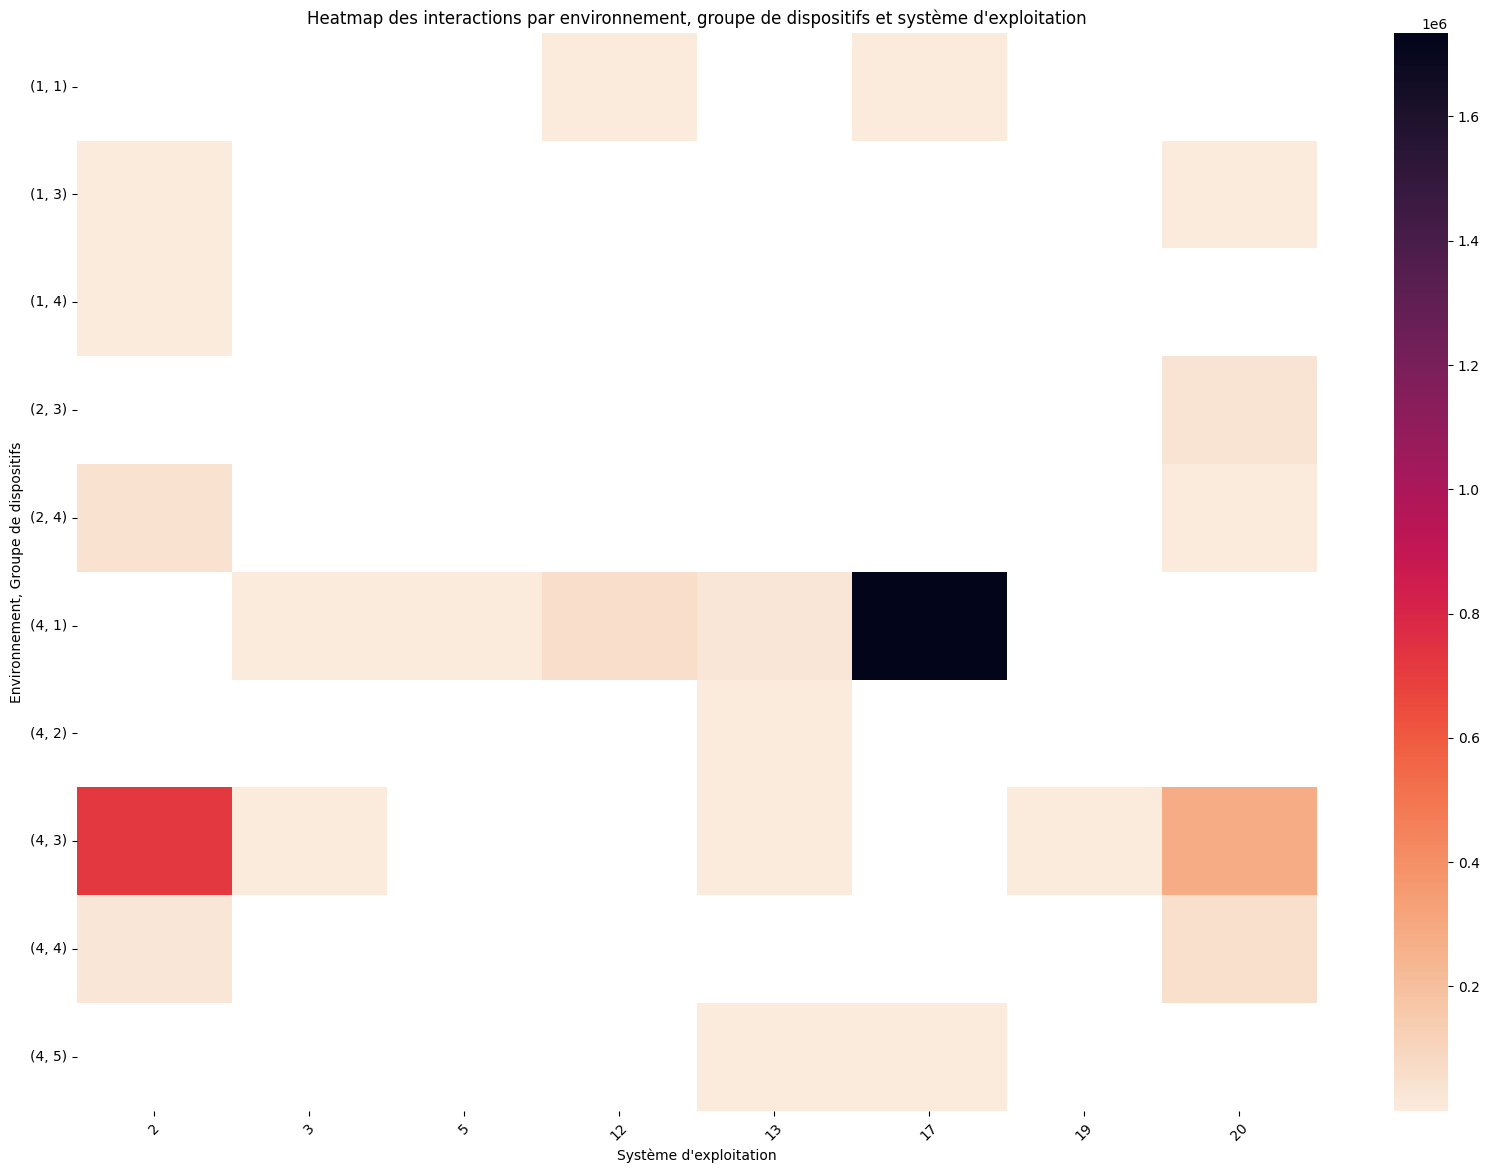

In [126]:
environment_device_os_counts = clicks_hour.groupby(['click_environment', 'click_deviceGroup', 'click_os']).size().reset_index(name='count')
heatmap_data = environment_device_os_counts.pivot(index=['click_environment', 'click_deviceGroup'], columns='click_os', values='count').fillna(0).astype(int)

plt.figure(figsize=(20, 14))
cmap = sns.cm.rocket_r
cmap.set_bad(color='white')

heatmap = sns.heatmap(heatmap_data, cmap=cmap, fmt="d", mask=(heatmap_data == 0))

heatmap.set_xticklabels(heatmap_data.columns, rotation=45)
heatmap.set_yticklabels(heatmap_data.index, rotation=0)
plt.title('Heatmap des interactions par environnement, groupe de dispositifs et système d\'exploitation')
plt.xlabel('Système d\'exploitation')
plt.ylabel('Environnement, Groupe de dispositifs')
plt.show()

Initialement, je pensais observer des systèmes d'exploitation spécifiques prédominants pour certains groupes d'appareils et environnements. Cependant, les données ne montrent pas de tendance claire ou de logique distincte reliant ces variables. Il n'y a pas de combinaison exclusive ou préférée d'appareil et de système d'exploitation qui domine dans un environnement particulier.

### Exploration des liens entre click_country et click_region

In [127]:
display(clicks_hour.groupby(['click_country', 'click_region']).size().reset_index(name='count'))

,click_country,click_region,count
0,1,1,7106
1,1,2,16716
2,1,3,3992
3,1,4,30189
4,1,5,96879
5,1,6,57203
6,1,7,63988
7,1,8,179076
8,1,9,84597
9,1,10,21980


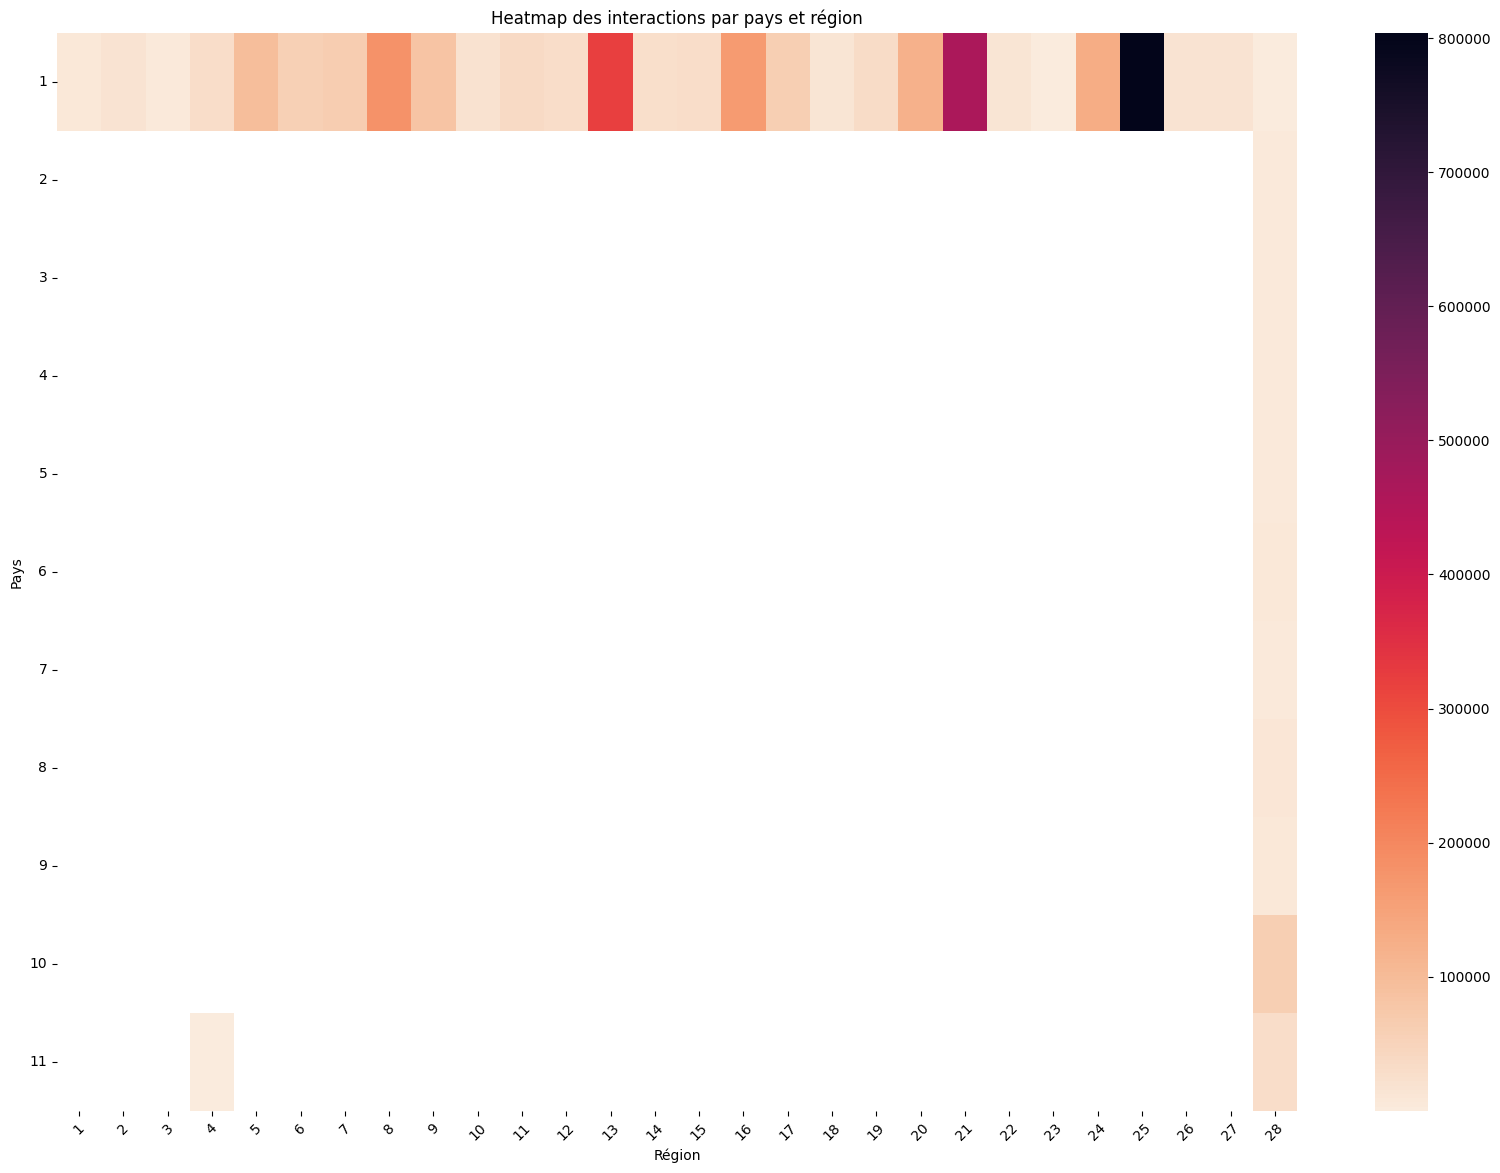

In [128]:
country_region_counts = clicks_hour.groupby(['click_country', 'click_region']).size().reset_index(name='count')
heatmap_data = country_region_counts.pivot(index='click_country', columns='click_region', values='count').fillna(0).astype(int)

plt.figure(figsize=(20, 14))
cmap = sns.cm.rocket_r
cmap.set_bad(color='white')

heatmap = sns.heatmap(heatmap_data, cmap=cmap, fmt="d", mask=(heatmap_data == 0))

heatmap.set_xticklabels(heatmap_data.columns, rotation=45)
heatmap.set_yticklabels(heatmap_data.index, rotation=0)
plt.title('Heatmap des interactions par pays et région')
plt.xlabel('Région')
plt.ylabel('Pays')
plt.show()

En analysant les interactions entre `click_country` et `click_region`, il semble que chaque pays utilise un système de numérotation interne pour ses régions, ce qui signifie que l'identifiant de région n'est pas global mais spécifique à chaque pays. Par exemple, bien que plusieurs pays montrent des interactions dans la région `28`, cela ne signifie pas nécessairement qu'ils se réfèrent à la même région géographique ou administrative.

Le `click_country` 1 présente une diversité de régions, de 1 à 28, suggérant une structure administrative interne complexe avec de nombreuses régions distinctes. En contraste, les données pour les autres pays montrent principalement des interactions avec la région `28`, ce qui pourrait indiquer que soit ces pays ont une prédominance d'activité dans cette région spécifique, soit que la collecte des données ou l'activité numérique est concentrée dans cette région pour des raisons non spécifiées.

Cette observation met en lumière l'importance de comprendre les conventions de numérotation des régions dans chaque pays pour interpréter correctement les données. Elle suggère également que les stratégies de marketing et d'analyse doivent être adaptées au contexte national plutôt qu'appliquées uniformément à travers les différents pays."

### Éliminer les lignes de clicks_hour associées à des articles_metadata inexistants

In [129]:
clicks_hour = clicks_hour[clicks_hour['click_article_id'].isin(articles_metadata['article_id'])]
display(clicks_hour.describe())

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2984503.00,2984503.00,2984503,2984503.00,2984503.00,2984503,2984503.00,2984503.00,2984503.00,2984503.00,2984503.00,2984503.00
mean,107950.72,1507472245395264.75,2017-10-08 14:17:25.063933696,3.90,194919.47,2017-10-08 14:50:43.817231360,3.94,1.82,13.27,1.36,18.31,1.84
min,0.00,1506825423271737.00,2017-10-01 02:37:03,2.00,3.00,2017-10-01 03:00:00.026000,1.00,1.00,2.00,1.00,1.00,1.00
25%,40325.00,1507124173739133.50,2017-10-04 13:36:13.500000,2.00,124228.00,2017-10-04 14:20:52.016499968,4.00,1.00,2.00,1.00,13.00,1.00
50%,86239.00,1507493357184462.00,2017-10-08 20:09:17,3.00,202381.00,2017-10-08 20:35:16.476999936,4.00,1.00,17.00,1.00,21.00,2.00
75%,163266.00,1507749437309023.00,2017-10-11 19:17:17,4.00,277067.00,2017-10-11 19:43:32.864499968,4.00,3.00,17.00,1.00,25.00,2.00
max,322896.00,1508211379189330.00,2017-10-17 03:36:19,124.00,364046.00,2017-11-13 20:03:44.886000,4.00,5.00,20.00,11.00,28.00,7.00
std,83652.03,385508878018.69,NaN,3.92,90773.51,NaN,0.34,1.04,6.88,1.73,7.06,1.16


In [130]:
display(articles_metadata.describe())
display(clicks_hour.describe())

,article_id,category_id,created_at_ts,publisher_id,words_count
count,364012.00,364012.00,364012,364012.00,364012.00
mean,182015.72,283.10,2016-09-17 01:12:17.696836864,0.00,190.92
min,0.00,0.00,2006-09-27 11:14:35,0.00,5.00
25%,91006.75,199.00,2015-10-15 17:31:10.249999872,0.00,159.00
50%,182010.50,301.00,2017-03-13 16:47:09,0.00,186.00
75%,273021.25,399.00,2017-11-05 14:21:57.500000,0.00,218.00
max,364046.00,460.00,2018-03-13 12:12:30,0.00,6690.00
std,105090.12,136.72,NaN,0.00,59.48


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2984503.00,2984503.00,2984503,2984503.00,2984503.00,2984503,2984503.00,2984503.00,2984503.00,2984503.00,2984503.00,2984503.00
mean,107950.72,1507472245395264.75,2017-10-08 14:17:25.063933696,3.90,194919.47,2017-10-08 14:50:43.817231360,3.94,1.82,13.27,1.36,18.31,1.84
min,0.00,1506825423271737.00,2017-10-01 02:37:03,2.00,3.00,2017-10-01 03:00:00.026000,1.00,1.00,2.00,1.00,1.00,1.00
25%,40325.00,1507124173739133.50,2017-10-04 13:36:13.500000,2.00,124228.00,2017-10-04 14:20:52.016499968,4.00,1.00,2.00,1.00,13.00,1.00
50%,86239.00,1507493357184462.00,2017-10-08 20:09:17,3.00,202381.00,2017-10-08 20:35:16.476999936,4.00,1.00,17.00,1.00,21.00,2.00
75%,163266.00,1507749437309023.00,2017-10-11 19:17:17,4.00,277067.00,2017-10-11 19:43:32.864499968,4.00,3.00,17.00,1.00,25.00,2.00
max,322896.00,1508211379189330.00,2017-10-17 03:36:19,124.00,364046.00,2017-11-13 20:03:44.886000,4.00,5.00,20.00,11.00,28.00,7.00
std,83652.03,385508878018.69,NaN,3.92,90773.51,NaN,0.34,1.04,6.88,1.73,7.06,1.16


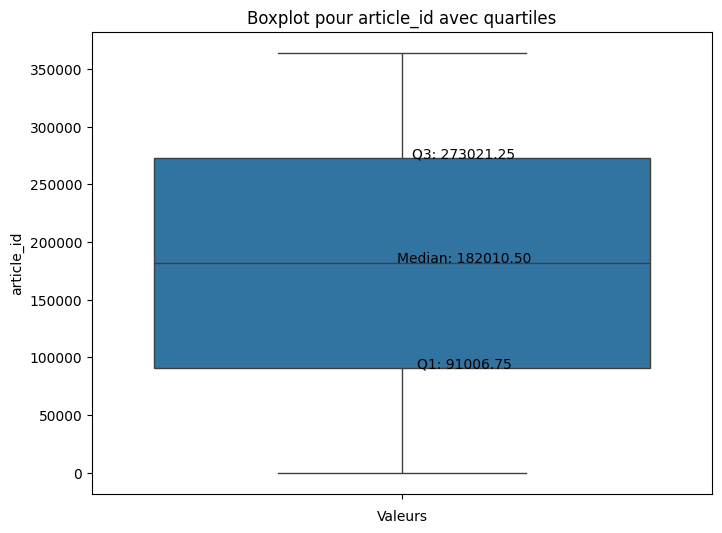

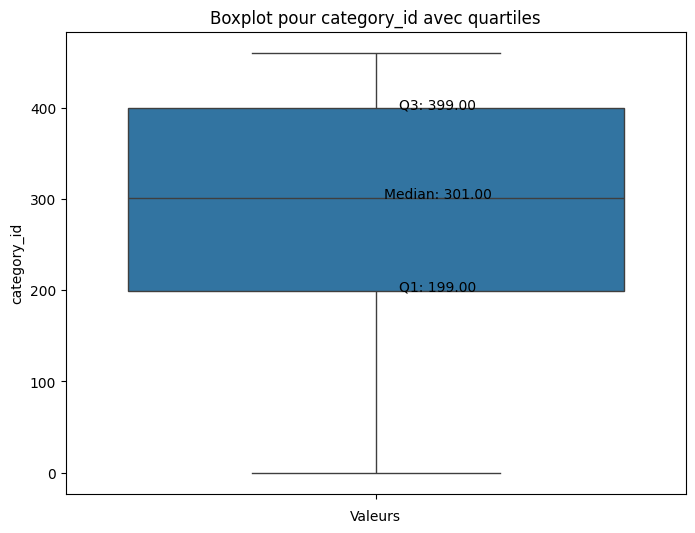

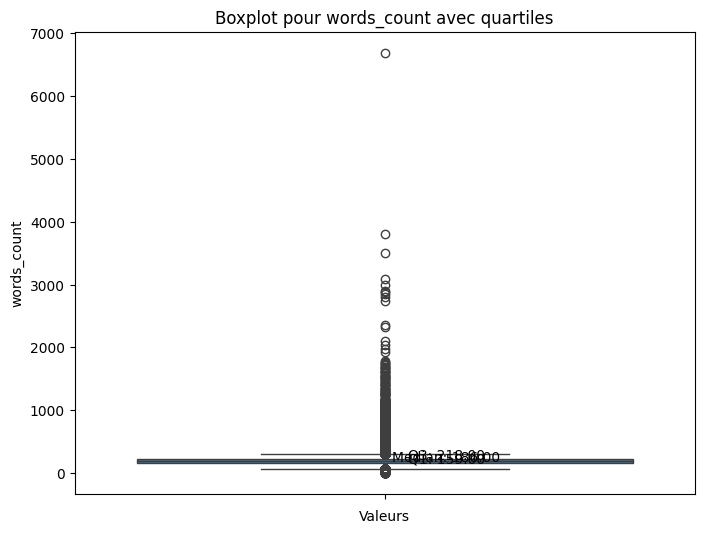

In [131]:
data = articles_metadata.drop(columns=['created_at_ts', 'publisher_id'])

for column in data.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=data[column])
    
    # Calculer les quartiles
    quartiles = data[column].quantile([0.25, 0.5, 0.75])
    Q1 = quartiles[0.25]
    Q3 = quartiles[0.75]
    median = quartiles[0.5]
    
    # Afficher les quartiles et la médiane en chiffre
    plt.text(0.1, Q1, f'Q1: {Q1:.2f}', fontsize=10, ha='center')
    plt.text(0.1, Q3, f'Q3: {Q3:.2f}', fontsize=10, ha='center')
    plt.text(0.1, median, f'Median: {median:.2f}', fontsize=10, ha='center')
    
    plt.title(f"Boxplot pour {column} avec quartiles")
    plt.ylabel(column)
    plt.xlabel("Valeurs")
    plt.show()

In [132]:
Q1 = articles_metadata['words_count'].quantile(0.25)
Q3 = articles_metadata['words_count'].quantile(0.75)
filtered_data = articles_metadata[(articles_metadata['words_count'] >= Q1) & (articles_metadata['words_count'] <= Q3)]

display(filtered_data.describe())
display(articles_metadata.describe())

,article_id,category_id,created_at_ts,publisher_id,words_count
count,183457.00,183457.00,183457,183457.00,183457.00
mean,186375.54,287.16,2016-09-29 20:39:17.379102208,0.00,186.99
min,0.00,0.00,2006-12-20 00:00:00,0.00,159.00
25%,93458.00,209.00,2015-11-02 20:00:01,0.00,173.00
50%,191726.00,309.00,2017-03-30 18:20:39,0.00,186.00
75%,278237.00,412.00,2017-11-08 18:32:28,0.00,201.00
max,364044.00,460.00,2018-03-13 12:12:30,0.00,218.00
std,106616.44,139.26,NaN,0.00,16.69


,article_id,category_id,created_at_ts,publisher_id,words_count
count,364012.00,364012.00,364012,364012.00,364012.00
mean,182015.72,283.10,2016-09-17 01:12:17.696836864,0.00,190.92
min,0.00,0.00,2006-09-27 11:14:35,0.00,5.00
25%,91006.75,199.00,2015-10-15 17:31:10.249999872,0.00,159.00
50%,182010.50,301.00,2017-03-13 16:47:09,0.00,186.00
75%,273021.25,399.00,2017-11-05 14:21:57.500000,0.00,218.00
max,364046.00,460.00,2018-03-13 12:12:30,0.00,6690.00
std,105090.12,136.72,NaN,0.00,59.48


In [133]:
display(filtered_data.shape[0]*100/articles_metadata.shape[0])

50.3986132325308

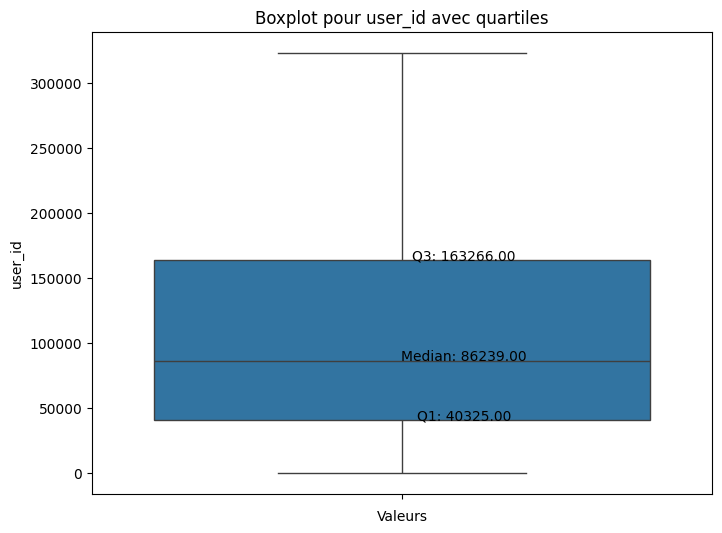

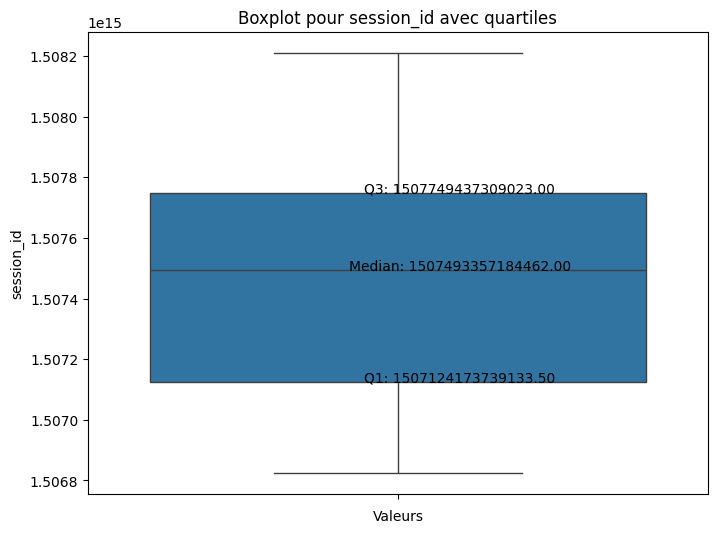

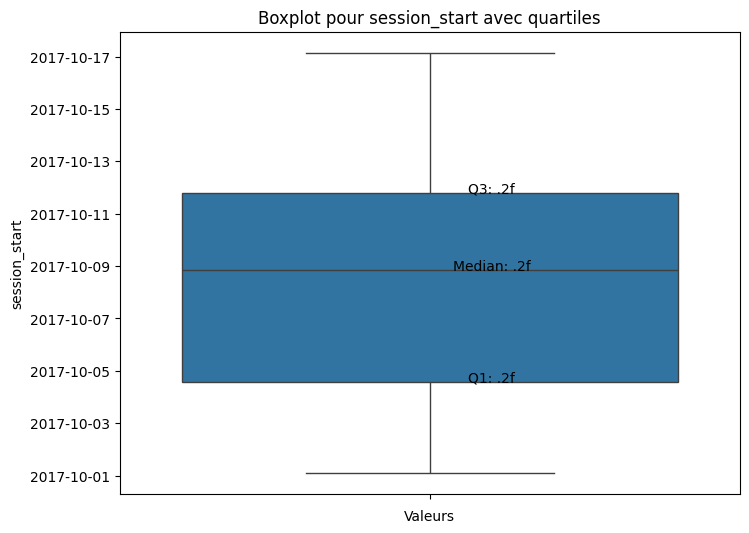

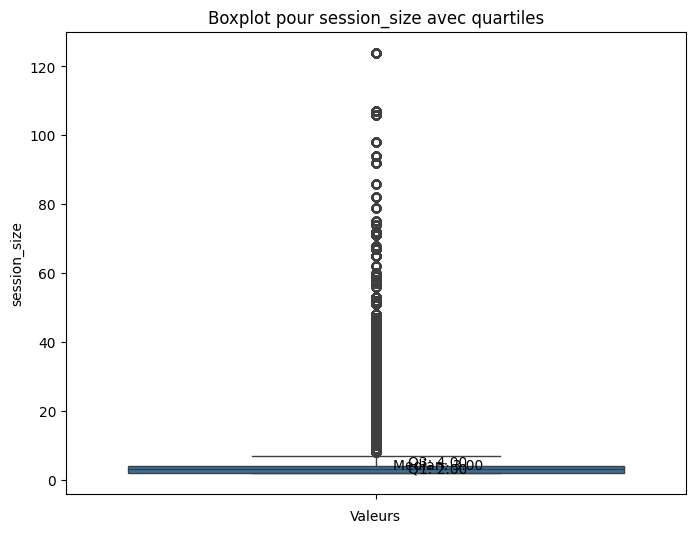

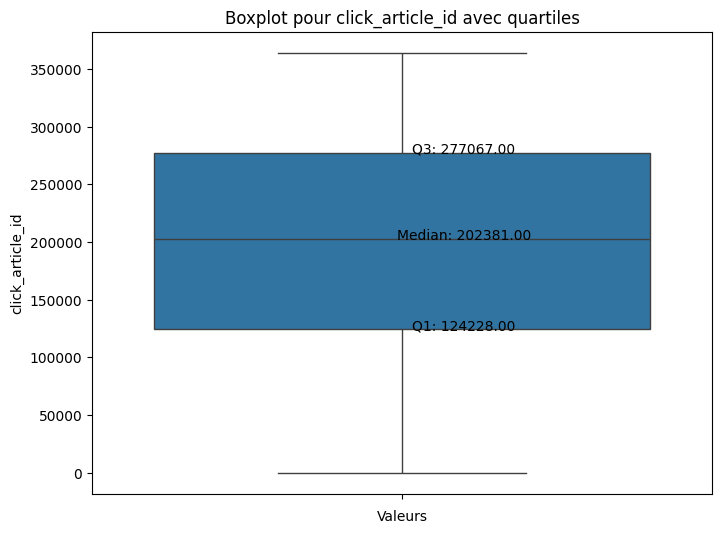

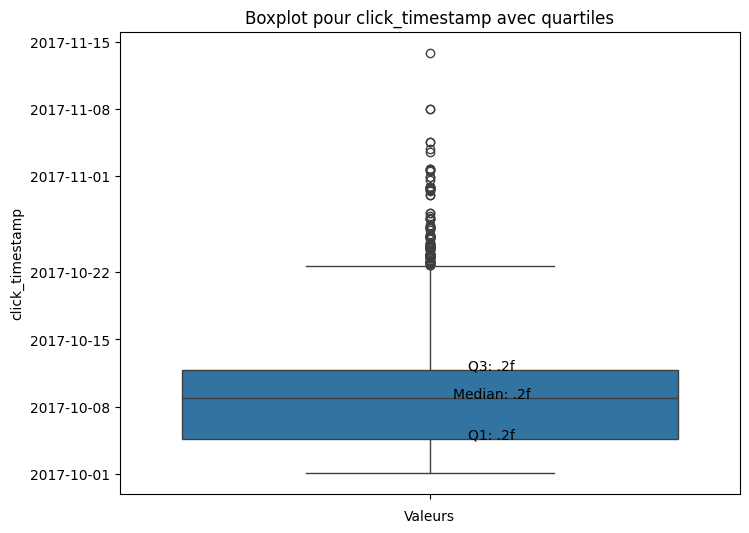

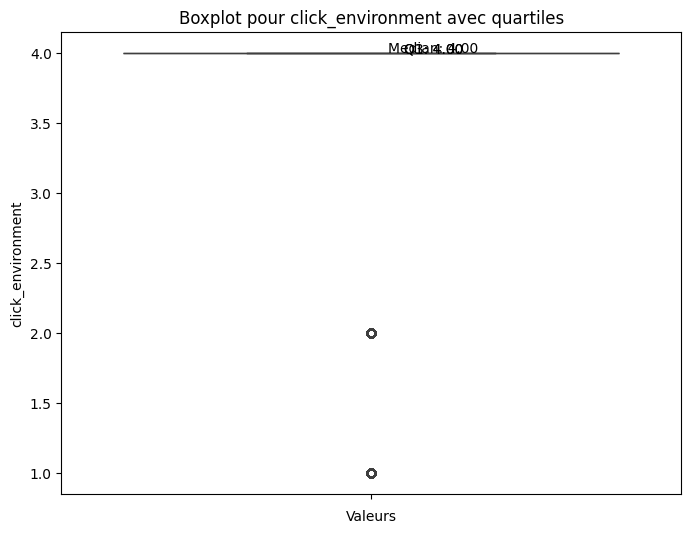

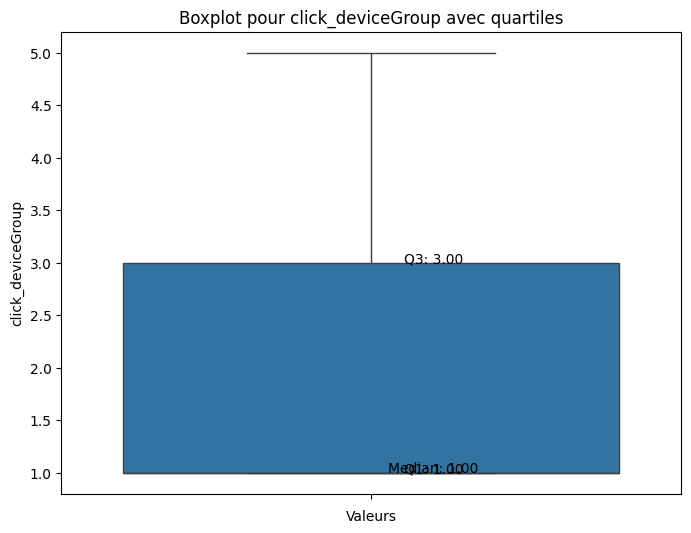

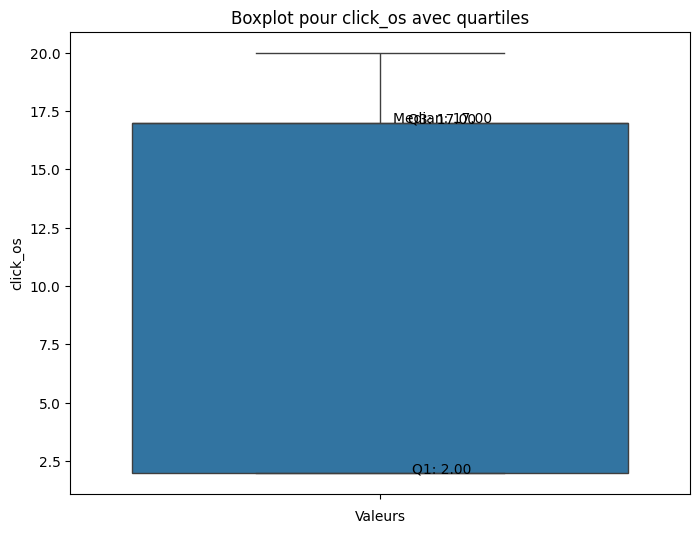

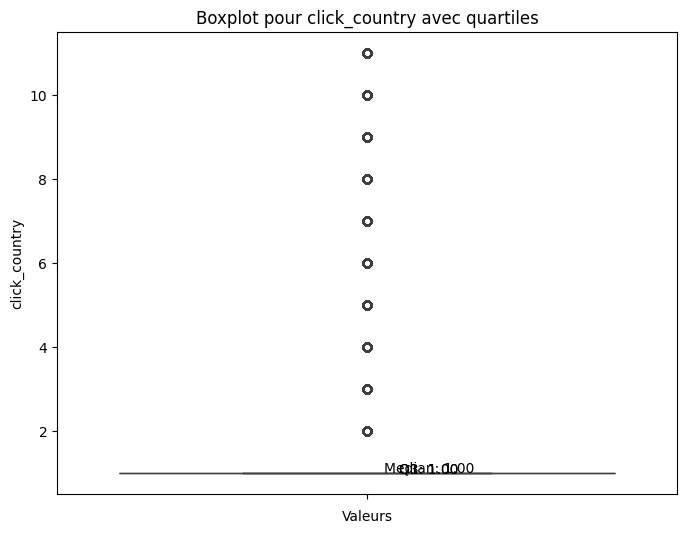

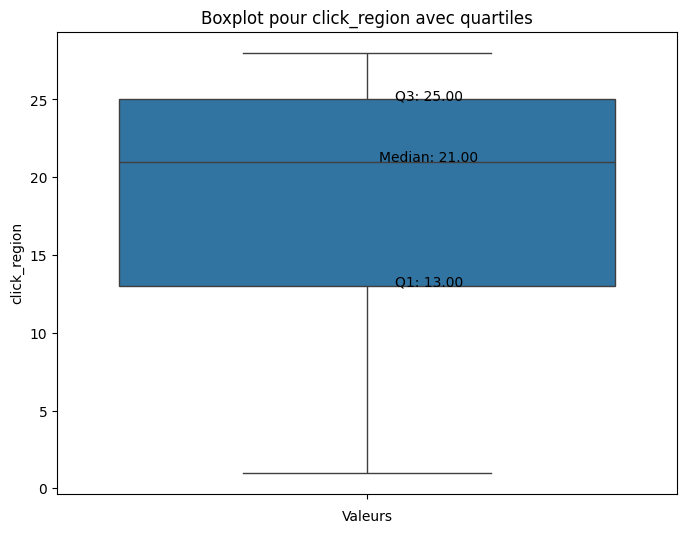

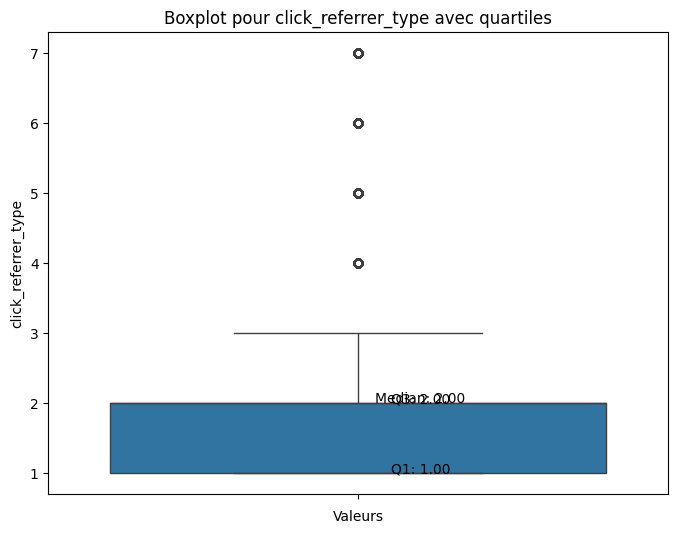

In [134]:
for column in clicks_hour.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=clicks_hour[column])
    
    # Calculer les quartiles
    quartiles = clicks_hour[column].quantile([0.25, 0.5, 0.75])
    Q1 = quartiles[0.25]
    Q3 = quartiles[0.75]
    median = quartiles[0.5]
    
    # Afficher les quartiles et la médiane en chiffre
    plt.text(0.1, Q1, f'Q1: {Q1:.2f}', fontsize=10, ha='center')
    plt.text(0.1, Q3, f'Q3: {Q3:.2f}', fontsize=10, ha='center')
    plt.text(0.1, median, f'Median: {median:.2f}', fontsize=10, ha='center')
    
    plt.title(f"Boxplot pour {column} avec quartiles")
    plt.ylabel(column)
    plt.xlabel("Valeurs")
    plt.show()

# Création du dataset

In [136]:
clicks = pd.merge(clicks_hour, articles_metadata, left_on='click_article_id', right_on='article_id', how='left')
selected_columns = ['user_id', 'article_id', 'category_id', 'words_count', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 'click_region', 'click_referrer_type']
clicks = clicks[selected_columns]

clicks.to_csv('data/clicks.csv', index=False)
display(clicks.describe())

,user_id,article_id,category_id,words_count,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2984503.00,2984503.00,2984503.00,2984503.00,2984503.00,2984503.00,2984503.00,2984503.00,2984503.00,2984503.00
mean,107950.72,194919.47,305.93,208.64,3.94,1.82,13.27,1.36,18.31,1.84
std,83652.03,90773.51,113.08,81.63,0.34,1.04,6.88,1.73,7.06,1.16
min,0.00,3.00,1.00,5.00,1.00,1.00,2.00,1.00,1.00,1.00
25%,40325.00,124228.00,250.00,173.00,4.00,1.00,2.00,1.00,13.00,1.00
50%,86239.00,202381.00,327.00,198.00,4.00,1.00,17.00,1.00,21.00,2.00
75%,163266.00,277067.00,409.00,232.00,4.00,3.00,17.00,1.00,25.00,2.00
max,322896.00,364046.00,460.00,6690.00,4.00,5.00,20.00,11.00,28.00,7.00


# Models

## Filtrage collaboratif

### Création du dataset

In [ ]:
clicks = pd.read_csv('data/clicks.csv')

user_article_interaction = clicks.groupby(['user_id', 'article_id']).size().reset_index(name='rating')
series = clicks.groupby(['user_id', 'article_id']).size()
user_rating_s = series.to_frame()
user_rating_s = user_rating_s.reset_index()
user_rating_s.rename(columns = {0:'raw_ratings'}, inplace = True)

display(user_rating_s)

NameError: name 'pd' is not defined

In [139]:
display(user_rating_s['raw_ratings'].max())
display(user_rating_s.sort_values(by='raw_ratings', ascending=False))

33

,user_id,article_id,raw_ratings
349477,16280,68851,33
349535,16280,237071,33
349580,16280,363925,33
349471,16280,43032,31
349465,16280,38823,30
...,...,...,...
991135,54283,352901,1
991136,54284,31520,1
991137,54284,48403,1
991138,54284,63307,1


In [141]:
scaler = MinMaxScaler(feature_range=(1, 5))
user_article_interaction_scaled = user_rating_s.copy()
user_article_interaction_scaled['raw_ratings'] = scaler.fit_transform(user_rating_s[['raw_ratings']])
user_article_interaction_scaled.to_csv('data/user_article_interaction_scaled.csv', index=False)

In [142]:
display(user_article_interaction_scaled.sort_values(by='raw_ratings', ascending=False))

,user_id,article_id,raw_ratings
349477,16280,68851,5.00
349535,16280,237071,5.00
349580,16280,363925,5.00
349471,16280,43032,4.75
349465,16280,38823,4.62
...,...,...,...
991135,54283,352901,1.00
991136,54284,31520,1.00
991137,54284,48403,1.00
991138,54284,63307,1.00


In [143]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(user_article_interaction_scaled[['user_id', 'article_id', 'raw_ratings']], reader)

### Train

In [144]:
algo = SVD()

result_SVD = cross_validate(algo, data, measures=['RMSE', 'MAE','MSE'], cv=5, verbose=True)

display(result_SVD)

Evaluating RMSE, MAE, MSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0369  0.0373  0.0371  0.0371  0.0379  0.0372  0.0003  
MAE (testset)     0.0171  0.0171  0.0170  0.0171  0.0171  0.0171  0.0000  
MSE (testset)     0.0014  0.0014  0.0014  0.0014  0.0014  0.0014  0.0000  
Fit time          28.60   28.97   28.02   29.39   30.21   29.04   0.74    
Test time         4.06    4.28    4.03    3.92    4.72    4.20    0.29    


{'test_rmse': array([0.03692121, 0.0372545 , 0.03705633, 0.03705487, 0.03786145]),
 'test_mae': array([0.01710921, 0.01712057, 0.01699309, 0.01712481, 0.01709266]),
 'test_mse': array([0.00136318, 0.0013879 , 0.00137317, 0.00137306, 0.00143349]),
 'fit_time': (28.59873390197754,
  28.968121767044067,
  28.015683889389038,
  29.39349937438965,
  30.209864854812622),
 'test_time': (4.059632062911987,
  4.281188488006592,
  4.0269622802734375,
  3.9197425842285156,
  4.724912881851196)}

### Evaluation

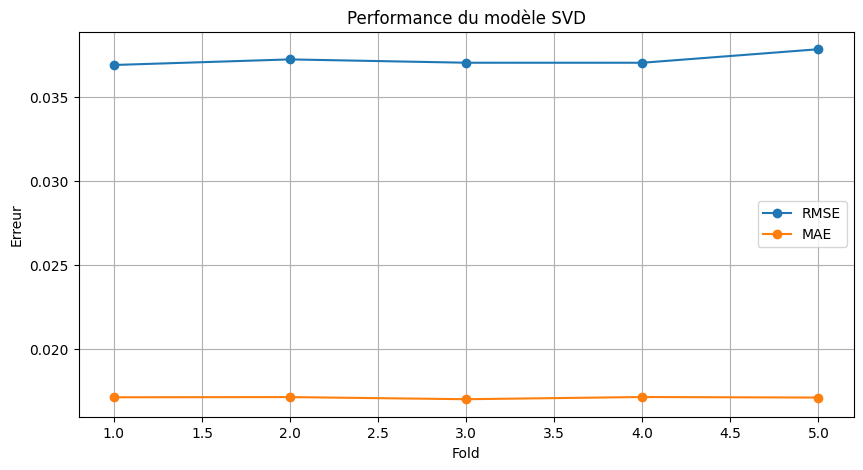

In [145]:
rmse_values = result_SVD['test_rmse']
mae_values = result_SVD['test_mae']

plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), rmse_values, label='RMSE', marker='o')
plt.plot(range(1, 6), mae_values, label='MAE', marker='o')
plt.title('Performance du modèle SVD')
plt.xlabel('Fold')
plt.ylabel('Erreur')
plt.legend()
plt.grid(True)
plt.show()

In [147]:
import os

os.makedirs("models", exist_ok=True)  # Crée le dossier s'il n'existe pas
joblib.dump(algo, "models/svd.joblib")  # Ensuite, ça marche !


['models/svd.joblib']

In [148]:
loaded_model = joblib.load('models/svd.joblib')

#### Test avec un nouveau utilisateur

In [7]:
user_id = 854120622
new_user_data = pd.DataFrame({'user_id': [user_id]*7, 'article_id': [68866, 87205, 87224,96755,157541,160158,233470], 'rating': [5, 5, 4,5,4,5,5]})

all_categories = user_article_interaction_scaled['article_id'].unique()

new_user_all_categories = pd.DataFrame({'article_id': all_categories})

new_user_all_categories['user_id'] = user_id

rating_map = new_user_data.set_index('article_id')['rating'].to_dict()

new_user_all_categories['rating'] = new_user_all_categories['article_id'].map(rating_map).fillna(0)

display(new_user_all_categories)

NameError: name 'user_article_interaction_scaled' is not defined

In [ ]:
reader = Reader(rating_scale=(0, 5))
new_user_data = Dataset.load_from_df(new_user_all_categories[['user_id', 'article_id', 'rating']], reader)

trainset = new_user_data.build_full_trainset()
loaded_model.fit(trainset)

In [ ]:
predictions = []
for article_id in new_user_all_categories['article_id'].unique():
    if rating_map.get(article_id, 0) == 0: 
        pred = loaded_model.predict(user_id, article_id)
        predictions.append((article_id, pred.est))

predicted_ratings = pd.DataFrame(predictions, columns=['article_id', 'predicted_rating'])

predicted_ratings = predicted_ratings.sort_values('predicted_rating', ascending=False)

display(predicted_ratings.head(5))

,article_id,predicted_rating
1332,5349,0.00
1348,121159,0.00
1560,214710,0.00
1105,292696,0.00
1033,156574,0.00


In [ ]:
display(user_article_interaction_scaled[user_article_interaction_scaled['user_id']==0])

,user_id,article_id,raw_ratings
0,0,68866,1.00
1,0,87205,1.00
2,0,87224,1.00
3,0,96755,1.00
4,0,157541,1.00
5,0,160158,1.00
6,0,233470,1.00
7,0,313996,1.00


## Content-based

In [158]:
clicks = pd.read_csv('data/clicks.csv')

user_article_interaction = clicks.groupby(['user_id', 'article_id']).size().reset_index(name='rating')

In [159]:
file_path = 'data/RAW/articles_embeddings.pickle'

with open(file_path, 'rb') as file:
    article_embeddings = pickle.load(file)

In [160]:
article_embeddings_df = pd.DataFrame(article_embeddings, index=range(article_embeddings.shape[0]))

In [161]:
def get_article_embedding(article_id):
    return article_embeddings_df.loc[article_id].values

In [162]:
class ModelEvaluator:
    def __init__(self, clicks, articles_df):
         # Les clics faits par les utilisateurs
        self.clicks = clicks
        # Le dataframe contenant des informations sur les articles
        self.articles_df = articles_df

    # Méthode pour obtenir un échantillon d'articles non interagis par un utilisateur
    def get_not_interacted_items_sample(self, user_id, sample_size, seed=42):
        # Articles avec lesquels l'utilisateur a interagi
        interacted_items = self.clicks[self.clicks['user_id'] == user_id]['article_id']
        # Tous les articles disponibles
        all_items = set(self.clicks['article_id'])
        all_items_df = pd.DataFrame({'article_id': list(all_items)})

        # Articles non interagis par l'utilisateur
        non_interacted_items_df = all_items_df[~all_items_df['article_id'].isin(interacted_items)]
        non_interacted_items = non_interacted_items_df['article_id'].tolist()

        random.seed(seed)
        # Sélection aléatoire d'un échantillon d'articles non interagis
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    # Méthode pour vérifier si un item est dans les recommandations top-n
    def _verify_hit_top_n(self, item_id, recommended_items, topn):
        try:
            # Vérifie si l'item est dans les recommandations
            index = next(i for i, c in enumerate(recommended_items) if c == item_id)
        except:
            index = -1
        # Vérifie si l'item est dans les top-n recommandations
        hit = int(index in range(0, topn))
        return hit, index

    # Méthode pour évaluer le modèle pour un utilisateur
    def evaluate_model_for_user(self, model, user_id):
        # Articles avec lesquels l'utilisateur a interagi dans l'ensemble de test
        interacted_items_testset = self.clicks[self.clicks['user_id'] == user_id]['article_id']
        # Nombre d'articles avec lesquels l'utilisateur a interagi
        interacted_items_count_testset = len(interacted_items_testset)

        # Recommandations pour l'utilisateur
        recommendations = model.recommend_items(user_id, topn=10000000000)
        # Convertir la liste ou le tableau NumPy en DataFrame
        person_recs_df = pd.DataFrame(recommendations, columns=['article_id'])

        hits_at_5_count = 0
        hits_at_10_count = 0
        for item_id in interacted_items_testset:
            # Échantillon d'articles non interagis
            non_interacted_items_sample = self.get_not_interacted_items_sample(user_id, sample_size=100, seed=item_id%(2**32))
            # Articles à filtrer des recommandations
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))
            # Recommandations valides
            valid_recs_df = person_recs_df[person_recs_df['article_id'].isin(items_to_filter_recs)]
            valid_recs = valid_recs_df['article_id'].values
            # Vérification de l'hit@5
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            # Vérification de l'hit@10
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        # Recall@5
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        # Recall@10
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count': hits_at_5_count,
                          'hits@10_count': hits_at_10_count,
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    # Méthode pour évaluer le modèle
    def evaluate_model(self, model):
        people_metrics = []
        # user_ids = self.clicks['user_id'].unique()
        # user_ids = [152810,303164,303165]
        user_ids = np.random.choice(self.clicks['user_id'].unique(), size=1000, replace=False)
        for user_id in user_ids:
            # Évaluation pour chaque utilisateur
            person_metrics = self.evaluate_model_for_user(model, user_id)
            person_metrics['_user_id'] = user_id
            people_metrics.append(person_metrics)

        detailed_results_df = pd.DataFrame(people_metrics) \
                           .sort_values('interacted_count', ascending=False)

        # Recall global@5
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        # Recall global@10
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())

        # Métriques globales
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}
        return global_metrics, detailed_results_df

class ContentBasedRecommender:
    MODEL_NAME = 'Content-Based'

    def __init__(self, articles_df):
        # DataFrame contenant les articles
        self.articles_df = articles_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, topn=5):
        # Récupérer les identifiants des articles cliqués par l'utilisateur
        clicked_articles = clicks[clicks['user_id'] == user_id]['article_id']
        # Récupérer les embeddings correspondants aux articles cliqués
        clicked_embeddings = self.articles_df.loc[clicked_articles].values
        
        # Calculer la similarité entre les embeddings des articles cliqués et tous les autres articles
        similarities = cosine_similarity(clicked_embeddings, article_embeddings)
        
        # Somme des scores de similarité pour chaque article par rapport à tous les articles cliqués
        summed_similarities = np.sum(similarities, axis=0)

        # Trier les indices des articles en fonction de la somme des similarités, en excluant les déjà cliqués
        recommended_indices = np.argsort(-summed_similarities)
        recommended_indices = [idx for idx in recommended_indices if idx not in clicked_articles][:topn]

        # Récupérer les identifiants des articles recommandés
        recommended_articles = self.articles_df.iloc[recommended_indices].index.tolist()

        return recommended_articles

model_evaluator = ModelEvaluator(clicks, article_embeddings_df)
content_based_recommender_model = ContentBasedRecommender(article_embeddings_df)

global_metrics, detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
display(global_metrics)

{'modelName': 'Content-Based',
 'recall@5': 0.5021899369725457,
 'recall@10': 0.6280311932485846}

In [163]:
class RandomRecommender:
    MODEL_NAME = 'Random'

    def __init__(self, articles_df):
        # DataFrame contenant les articles
        self.articles_df = articles_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, topn=5):
        # Sélection aléatoire d'articles
        num_articles = len(self.articles_df)
        topn = min(topn, num_articles)
        random_articles = np.random.choice(self.articles_df.index, size=topn, replace=False)
        return random_articles.tolist()
    
random_recommender_model = RandomRecommender(article_embeddings_df)
global_metrics, detailed_results_df = model_evaluator.evaluate_model(random_recommender_model)
display(global_metrics)

{'modelName': 'Random',
 'recall@5': 0.04841897233201581,
 'recall@10': 0.09892402283706632}